In [ ]:
!pip -q install --upgrade pip
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install open_clip_torch==2.24.0
!pip -q install datasets==2.21.0
!pip -q install scikit-learn==1.5.2
!pip -q install tqdm==4.66.5
!pip -q install lpips==0.1.4
!pip -q install matplotlib==3.9.2
!pip -q install scipy==1.13.1
!pip -q install networkx==3.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompat

In [ ]:
import os, math, random, itertools
from dataclasses import dataclass
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets as tvds, transforms as T
from torch.utils.data import DataLoader
import open_clip
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import linalg
import lpips
import matplotlib.pyplot as plt
import networkx as nx
from datasets import load_dataset
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
@dataclass
class Config:
    clip_model_name: str = 'ViT-B-32'
    clip_pretrained: str = 'openai'
    image_size: int = 224
    batch_size: int = 256
    num_workers: int = 2
    max_per_class: int = 1000
    sample_A: int = 6000
    sample_B: int = 6000
    clusters: int = 10
    topk_nn: int = 5
    lpips_pairs: int = 800
    # graph params
    knn_k: int = 8
    gin_hidden: int = 256
    gin_layers: int = 3
CFG = Config()
CFG


Config(clip_model_name='ViT-B-32', clip_pretrained='openai', image_size=224, batch_size=256, num_workers=2, max_per_class=1000, sample_A=6000, sample_B=6000, clusters=10, topk_nn=5, lpips_pairs=800, knn_k=8, gin_hidden=256, gin_layers=3)

In [ ]:
def build_clip(model_name=CFG.clip_model_name, pretrained=CFG.clip_pretrained):
    model, _, preprocess = open_clip.create_model_and_transforms(
        model_name, pretrained=pretrained, device=DEVICE)
    model.eval()
    return model, preprocess
clip_model, clip_preprocess = build_clip()
print('CLIP ready on', DEVICE)


100%|███████████████████████████████████████| 354M/354M [00:07<00:00, 49.9MiB/s]


CLIP ready on cpu


In [ ]:
def make_transform(image_size=CFG.image_size):
    return T.Compose([
        T.Resize((image_size, image_size), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                    std=(0.26862954, 0.26130258, 0.27577711)),
    ])

def load_cifar10_subset_by_class(root='./data', max_per_class=CFG.max_per_class):
    base = tvds.CIFAR10(root=root, train=True, download=True)
    class_to_indices = {i: [] for i in range(10)}
    for idx, (_, y) in enumerate(base):
        if len(class_to_indices[y]) < max_per_class:
            class_to_indices[y].append(idx)
    tx = make_transform()
    class SubsetWrap(torch.utils.data.Dataset):
        def __init__(self, base, idxs, transform):
            self.base, self.idxs, self.transform = base, idxs, transform
        def __len__(self): return len(self.idxs)
        def __getitem__(self, i):
            x, y = self.base[self.idxs[i]]
            return self.transform(x), y
    def subset(indices):
        return SubsetWrap(base, indices, tx)
    return {c: subset(idxs) for c, idxs in class_to_indices.items()}, base.classes

def load_cifake(split='train'):
    ds = load_dataset('dragonintelligence/CIFAKE-image-dataset', split=split)
    tx = make_transform()
    class HFWrap(torch.utils.data.Dataset):
        def __init__(self, ds, transform):
            self.ds, self.transform = ds, transform
        def __len__(self): return len(self.ds)
        def __getitem__(self, i):
            rec = self.ds[i]
            img = rec['image'].convert('RGB')
            y = int(rec['label'])
            return self.transform(img), y
    return HFWrap(ds, tx)


In [ ]:
@torch.no_grad()
def embed_dataset(dset, model, batch_size=CFG.batch_size, num_workers=CFG.num_workers, limit=None):
    loader = DataLoader(dset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
    feats, labels = [], []
    seen = 0
    for xb, yb in tqdm(loader, total=len(loader)):
        xb = xb.to(DEVICE)
        f = model.encode_image(xb)
        f = F.normalize(f, dim=-1).cpu().numpy()
        feats.append(f)
        labels.append(yb.numpy())
        seen += len(xb)
        if limit is not None and seen >= limit:
            break
    X = np.concatenate(feats, 0)
    y = np.concatenate(labels, 0)
    if limit is not None and len(X) > limit:
        X, y = X[:limit], y[:limit]
    return X, y


In [ ]:
def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fd = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return float(fd)

def gaussian_fit(X):
    mu = X.mean(0)
    centered = X - mu
    sigma = np.cov(centered, rowvar=False)
    if sigma.ndim == 0:
        sigma = np.array([[sigma]])
    return mu, sigma

def global_alignment_similarity(XA, XB, boot_splits=4):
    muA, sigA = gaussian_fit(XA)
    muB, sigB = gaussian_fit(XB)
    fd = frechet_distance(muA, sigA, muB, sigB)
    parts = np.array_split(np.random.permutation(len(XA)), boot_splits)
    fds = []
    for i in range(boot_splits-1):
        idx1, idx2 = parts[i], parts[i+1]
        mu1, s1 = gaussian_fit(XA[idx1])
        mu2, s2 = gaussian_fit(XA[idx2])
        fds.append(frechet_distance(mu1, s1, mu2, s2))
    scale = np.median(fds) if len(fds) else (fd + 1e-6)
    sim = math.exp(-fd / (scale + 1e-8))
    return float(np.clip(sim, 0, 1)), fd, scale

def coverage_similarity(XA, XB, k=CFG.topk_nn):
    nbrA = NearestNeighbors(n_neighbors=k+1).fit(XA)
    dA,_ = nbrA.kneighbors(XA)
    rA = np.median(dA[:, -1])
    nbrB = NearestNeighbors(n_neighbors=k+1).fit(XB)
    dB,_ = nbrB.kneighbors(XB)
    rB = np.median(dB[:, -1])
    nnAB = NearestNeighbors(n_neighbors=1).fit(XB)
    dAB,_ = nnAB.kneighbors(XA)
    covA = float(np.mean((dAB[:,0] <= rA).astype(np.float32)))
    nnBA = NearestNeighbors(n_neighbors=1).fit(XA)
    dBA,_ = nnBA.kneighbors(XB)
    covB = float(np.mean((dBA[:,0] <= rB).astype(np.float32)))
    return 0.0 if covA + covB == 0 else 2*covA*covB/(covA+covB)

lpips_model = lpips.LPIPS(net='alex').to(DEVICE).eval()
@torch.no_grad()
def lpips_similarity(dsA, dsB, n_pairs=CFG.lpips_pairs):
    nA, nB = len(dsA), len(dsB)
    idxA = np.random.choice(nA, size=min(n_pairs, nA), replace=nA<n_pairs)
    idxB = np.random.choice(nB, size=min(n_pairs, nB), replace=nB<n_pairs)
    def denorm_clip(x):
        mean = torch.tensor([0.48145466,0.4578275,0.40821073], device=DEVICE).view(1,3,1,1)
        std  = torch.tensor([0.26862954,0.26130258,0.27577711], device=DEVICE).view(1,3,1,1)
        return (x*std + mean - 0.5)/0.5
    vals = []
    for ia, ib in tqdm(list(zip(idxA, idxB)), desc='LPIPS pairs'):
        xa,_ = dsA[int(ia)]; xb,_ = dsB[int(ib)]
        xa = denorm_clip(xa.unsqueeze(0).to(DEVICE))
        xb = denorm_clip(xb.unsqueeze(0).to(DEVICE))
        vals.append(lpips_model(xa, xb).item())
    vals = np.array(vals, np.float32)
    lo, hi = float(np.percentile(vals,5)), float(np.percentile(vals,95))
    hi = max(hi, lo+1e-6)
    sim = float(np.clip(1.0 - (vals.mean()-lo)/(hi-lo), 0, 1))
    return sim, float(vals.mean())


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 161MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
@dataclass
class GINSResult:
    G: float; I: float; N: float; S: float
    FD: float; FD_scale: float; LPIPS_mean: float
    overall: float

def centroid_cosine(A_centroids, B_centroids):
    common = sorted(set(A_centroids.keys()) & set(B_centroids.keys()))
    if not common: return 0.0
    sims = []
    for k in common:
        a, b = A_centroids[k], B_centroids[k]
        s = float(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)+1e-8))
        sims.append((s+1)/2)
    return float(np.mean(sims))

def intra_alignment_similarity(XA, yA, XB, yB, known_labels: bool):
    if known_labels:
        labels = sorted(set(yA.tolist()) & set(yB.tolist()))
        A_cent = {c: XA[yA==c].mean(0) for c in labels}
        B_cent = {c: XB[yB==c].mean(0) for c in labels}
        return centroid_cosine(A_cent, B_cent)
    else:
        AC = {j: KMeans(n_clusters=CFG.clusters, n_init=10, random_state=SEED).fit(XA).cluster_centers_[j] for j in range(CFG.clusters)}
        BC = {j: KMeans(n_clusters=CFG.clusters, n_init=10, random_state=SEED).fit(XB).cluster_centers_[j] for j in range(CFG.clusters)}
        # crude matching via max cosine (for simplicity)
        sims = []
        for j in AC:
            a = AC[j]
            best = max((np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)+1e-8) for b in BC.values()))
            sims.append((best+1)/2)
        return float(np.mean(sims))

def compute_GINS(dsA, dsB, labeled=False, limitA=None, limitB=None):
    XA, yA = embed_dataset(dsA, clip_model, limit=limitA)
    XB, yB = embed_dataset(dsB, clip_model, limit=limitB)
    G_sim, fd, fd_scale = global_alignment_similarity(XA, XB)
    I_sim = intra_alignment_similarity(XA, yA, XB, yB, known_labels=labeled)
    N_sim = coverage_similarity(XA, XB)
    S_sim, lp_mean = lpips_similarity(dsA, dsB)
    overall = float(np.mean([G_sim, I_sim, N_sim, S_sim]))
    return GINSResult(G_sim, I_sim, N_sim, S_sim, fd, fd_scale, lp_mean, overall)

def print_gins(res: GINSResult, title='GINS Similarity'):
    print(f'==== {title} ====')
    print(f'G (Global) : {res.G:.3f}  [FD={res.FD:.3f}, scale={res.FD_scale:.3f}]')
    print(f'I (Intra)  : {res.I:.3f}')
    print(f'N (Cover)  : {res.N:.3f}')
    print(f'S (Style)  : {res.S:.3f}  [LPIPS mean={res.LPIPS_mean:.4f}]')
    print(f'Overall    : {res.overall:.3f}')


## GIN‑S: Graph‑based structural similarity

In [ ]:
def build_knn_graph(X, k=8, sym=True):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    dists, idxs = nbrs.kneighbors(X)
    N = X.shape[0]
    edges = []
    for i in range(N):
        for j in idxs[i,1:]:  # skip self
            edges.append((i,int(j)))
            if sym:
                edges.append((int(j), i))
    # unique
    edges = list(set(edges))
    src = torch.tensor([e[0] for e in edges], dtype=torch.long)
    dst = torch.tensor([e[1] for e in edges], dtype=torch.long)
    return src, dst


In [ ]:
class GINLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim), nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )
        self.eps = nn.Parameter(torch.zeros(1))
    def forward(self, x, src, dst):
        N = x.size(0)
        msg = torch.zeros_like(x)
        msg.index_add_(0, dst, x[src])
        out = self.mlp((1 + self.eps) * x + msg)
        return out

class GINEncoder(nn.Module):
    def __init__(self, in_dim, hidden=256, layers=3):
        super().__init__()
        dims = [in_dim] + [hidden]*(layers)
        self.layers = nn.ModuleList([
            GINLayer(dims[i], dims[i+1]) for i in range(layers)
        ])
    def forward(self, x, src, dst):
        h = x
        for layer in self.layers:
            h = layer(h, src, dst)
        g = h.mean(dim=0, keepdim=True)  # (1, D)
        g = F.normalize(g, dim=-1)
        return g


In [ ]:
@torch.no_grad()
def compute_gins_graph_similarity(XA, XB, k=CFG.knn_k):
    in_dim = XA.shape[1]
    enc = GINEncoder(in_dim, hidden=CFG.gin_hidden, layers=CFG.gin_layers).to(DEVICE)
    srcA, dstA = build_knn_graph(XA, k=k)
    srcB, dstB = build_knn_graph(XB, k=k)
    xA = torch.from_numpy(XA).float().to(DEVICE)
    xB = torch.from_numpy(XB).float().to(DEVICE)
    gA = enc(xA, srcA.to(DEVICE), dstA.to(DEVICE))  # (1,D)
    gB = enc(xB, srcB.to(DEVICE), dstB.to(DEVICE))
    sim = F.cosine_similarity(gA, gB).item()
    # map [-1,1]→[0,1]
    return (sim+1)/2, gA.squeeze(0).cpu().numpy(), gB.squeeze(0).cpu().numpy()


In [ ]:
def plot_semantic_graph(X, y=None, k=8, title='Graph', max_nodes=400):
    Xp = X[:max_nodes]
    if y is not None:
        yp = y[:max_nodes]
    else:
        yp = None
    src, dst = build_knn_graph(Xp, k=k)
    G = nx.Graph()
    G.add_nodes_from(range(len(Xp)))
    edges = list(zip(src.tolist(), dst.tolist()))
    G.add_edges_from(edges)
    # 2D projection
    pca = PCA(n_components=2, random_state=SEED)
    X2 = pca.fit_transform(Xp)
    pos = {i: (X2[i,0], X2[i,1]) for i in range(len(Xp))}
    plt.figure(figsize=(7,6))
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
    if yp is not None:
        nx.draw_networkx_nodes(G, pos, node_size=20, node_color=yp, cmap=plt.cm.tab20)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=20)
    plt.title(title)
    plt.axis('off')
    plt.show()


## Demo 1 — CIFAR‑10: Cat vs Dog graphs + GINS and GIN‑S

In [ ]:
c10_by_class, class_names = load_cifar10_subset_by_class(max_per_class=CFG.max_per_class)
class_names


100%|██████████| 170M/170M [00:02<00:00, 66.3MB/s]


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
XA, yA = embed_dataset(c10_by_class[3], clip_model)  # cat
XB, yB = embed_dataset(c10_by_class[5], clip_model)  # dog
print('Shapes:', XA.shape, XB.shape)


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 4/4 [02:57<00:00, 44.34s/it]

Shapes: (1000, 512) (1000, 512)


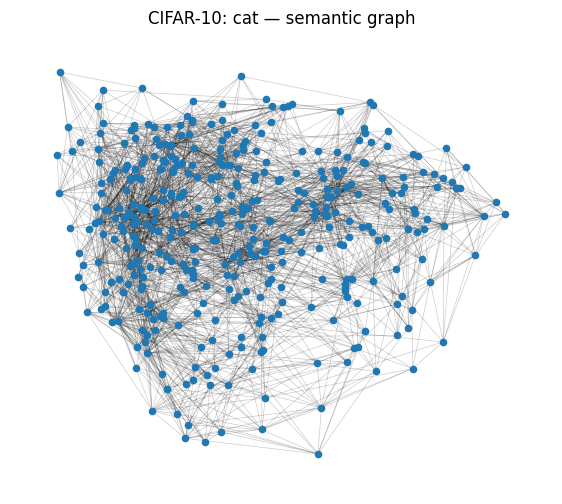

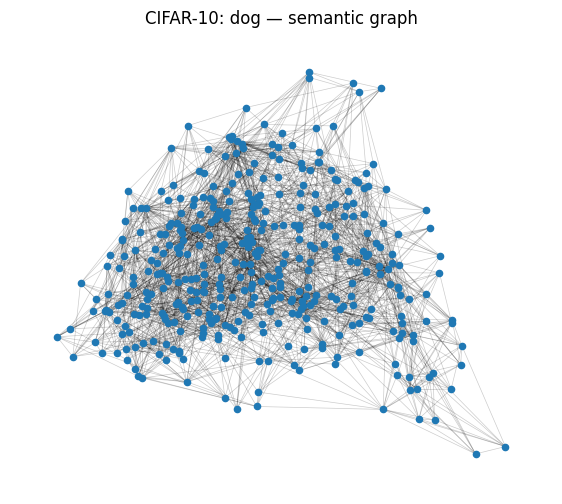

In [ ]:
# Plot semantic graphs (subset for clarity)
plot_semantic_graph(XA, y=None, k=CFG.knn_k, title='CIFAR-10: cat — semantic graph', max_nodes=400)
plot_semantic_graph(XB, y=None, k=CFG.knn_k, title='CIFAR-10: dog — semantic graph', max_nodes=400)


In [ ]:
# Compute classic GINS (label-aware intra alignment)
res = compute_GINS(c10_by_class[3], c10_by_class[5], labeled=True, limitA=CFG.max_per_class, limitB=CFG.max_per_class)
print_gins(res, title='GINS[cat vs dog]')


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
LPIPS pairs: 100%|██████████| 800/800 [00:57<00:00, 13.85it/s]

==== GINS[cat vs dog] ====
G (Global) : 0.225  [FD=0.069, scale=0.046]
I (Intra)  : 0.000
N (Cover)  : 0.364
S (Style)  : 0.553  [LPIPS mean=0.6405]
Overall    : 0.286


In [ ]:
# Compute GIN‑S graph similarity
gin_s, gA, gB = compute_gins_graph_similarity(XA, XB, k=CFG.knn_k)
print(f'GIN‑S (graph-level cosine mapped to [0,1]): {gin_s:.3f}')


GIN‑S (graph-level cosine mapped to [0,1]): 0.987


## Demo 2 — CIFAR‑10: Car vs Truck graphs + comparison table

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 4/4 [03:04<00:00, 46.10s/it]


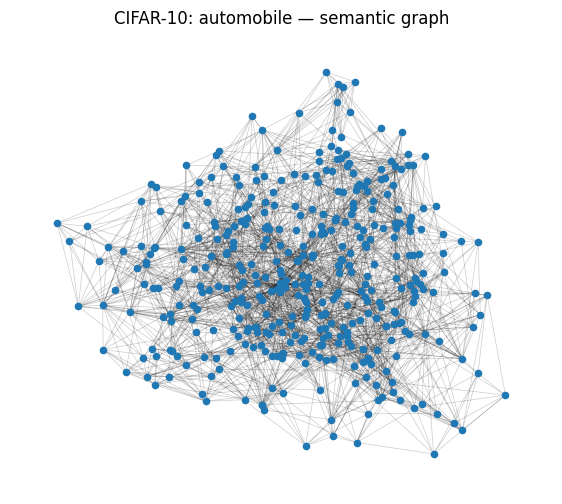

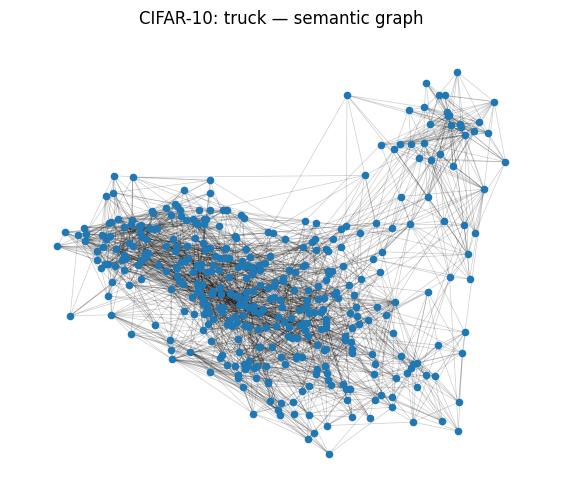

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
LPIPS pairs: 100%|██████████| 800/800 [00:58<00:00, 13.66it/s]


==== GINS[automobile vs truck] ====
G (Global) : 0.030  [FD=0.176, scale=0.050]
I (Intra)  : 0.000
N (Cover)  : 0.062
S (Style)  : 0.542  [LPIPS mean=0.6393]
Overall    : 0.159
GIN‑S (graph-level cosine mapped to [0,1]): 0.984


In [ ]:
XC, yC = embed_dataset(c10_by_class[1], clip_model)  # automobile
XD, yD = embed_dataset(c10_by_class[9], clip_model)  # truck
plot_semantic_graph(XC, k=CFG.knn_k, title='CIFAR-10: automobile — semantic graph', max_nodes=400)
plot_semantic_graph(XD, k=CFG.knn_k, title='CIFAR-10: truck — semantic graph', max_nodes=400)
res_ct = compute_GINS(c10_by_class[1], c10_by_class[9], labeled=True, limitA=CFG.max_per_class, limitB=CFG.max_per_class)
gin_s_ct, _, _ = compute_gins_graph_similarity(XC, XD, k=CFG.knn_k)
print_gins(res_ct, title='GINS[automobile vs truck]')
print(f'GIN‑S (graph-level cosine mapped to [0,1]): {gin_s_ct:.3f}')


## Demo 3 — CIFAKE: Real vs Generated with GINS + GIN‑S

In [ ]:

# Save model checkpoint
torch.save(model.state_dict(), "checkpoint.pt")


In [ ]:
def make_transform(image_size=224):
    return T.Compose([
        T.Resize((image_size, image_size), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                    std=(0.26862954, 0.26130258, 0.27577711)),
    ])

def load_cifake(split='train'):
    ds = load_dataset('dragonintelligence/CIFAKE-image-dataset', split=split)
    tx = make_transform()

    class HFWrap(torch.utils.data.Dataset):
        def __init__(self, ds, transform):
            self.ds, self.transform = ds, transform
        def __len__(self): return len(self.ds)
        def __getitem__(self, i):
            rec = self.ds[i]
            img = rec['image'].convert('RGB')
            y = int(rec['label'])
            return self.transform(img), y

    return HFWrap(ds, tx)


In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    clip_model_name: str = 'ViT-B-32'
    clip_pretrained: str = 'openai'
    image_size: int = 224
    batch_size: int = 256
    num_workers: int = 2
    max_per_class: int = 1000
    sample_A: int = 6000      # number of real samples to use
    sample_B: int = 6000      # number of fake samples to use
    clusters: int = 10
    topk_nn: int = 5
    lpips_pairs: int = 800
    knn_k: int = 8
    gin_hidden: int = 256
    gin_layers: int = 3

CFG = Config()
print("✅ CFG ready")


✅ CFG ready


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def embed_dataset(dset, model, batch_size=256, num_workers=2, limit=None):
    """Embed an image dataset using a CLIP model."""
    loader = DataLoader(dset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
    feats, labels = [], []
    seen = 0
    for xb, yb in tqdm(loader, total=len(loader)):
        xb = xb.to('cuda' if torch.cuda.is_available() else 'cpu')
        f = model.encode_image(xb)
        f = F.normalize(f, dim=-1).cpu().numpy()
        feats.append(f)
        labels.append(yb.numpy())
        seen += len(xb)
        if limit is not None and seen >= limit:
            break
    X = np.concatenate(feats, 0)
    y = np.concatenate(labels, 0)
    if limit is not None and len(X) > limit:
        X, y = X[:limit], y[:limit]
    return X, y


  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 96%|█████████▌| 23/24 [17:22<00:45, 45.34s/it]


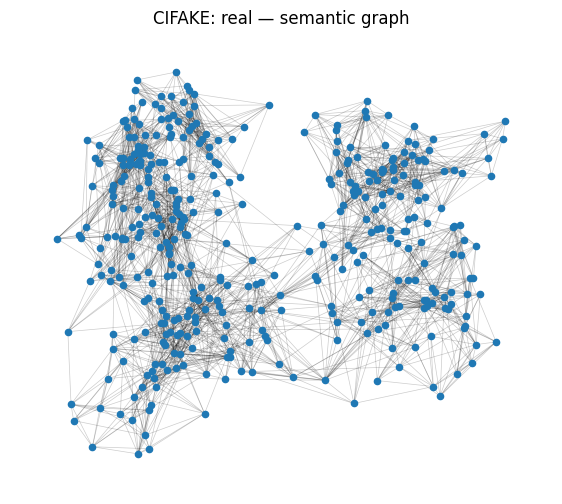

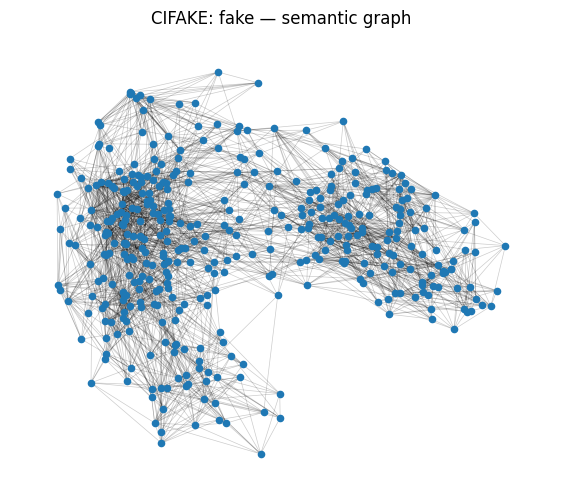

  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 96%|█████████▌| 23/24 [17:09<00:44, 44.78s/it]


NameError: name 'global_alignment_similarity' is not defined

In [ ]:
cifake = load_cifake('train')
idx_real = [i for i in range(len(cifake)) if cifake[i][1]==0]
idx_fake = [i for i in range(len(cifake)) if cifake[i][1]==1]
class SubsetWrap(torch.utils.data.Dataset):
    def __init__(self, base, idxs):
        self.base, self.idxs = base, idxs
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i): return self.base[self.idxs[i]]
real_ds = SubsetWrap(cifake, idx_real[:CFG.sample_A])
fake_ds = SubsetWrap(cifake, idx_fake[:CFG.sample_B])
XA_rf, yA_rf = embed_dataset(real_ds, clip_model, limit=CFG.sample_A)
XB_rf, yB_rf = embed_dataset(fake_ds, clip_model, limit=CFG.sample_B)
plot_semantic_graph(XA_rf, k=CFG.knn_k, title='CIFAKE: real — semantic graph', max_nodes=400)
plot_semantic_graph(XB_rf, k=CFG.knn_k, title='CIFAKE: fake — semantic graph', max_nodes=400)
res_rf = compute_GINS(real_ds, fake_ds, labeled=False, limitA=CFG.sample_A, limitB=CFG.sample_B)
print_gins(res_rf, title='GINS[CIFAKE real vs fake]')
gin_s_rf, _, _ = compute_gins_graph_similarity(XA_rf, XB_rf, k=CFG.knn_k)
print(f'GIN‑S (graph-level cosine mapped to [0,1]): {gin_s_rf:.3f}')


/tmp/ipython-input-1147338490.py:59: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1147338490.py:59: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1147338490.py:59: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


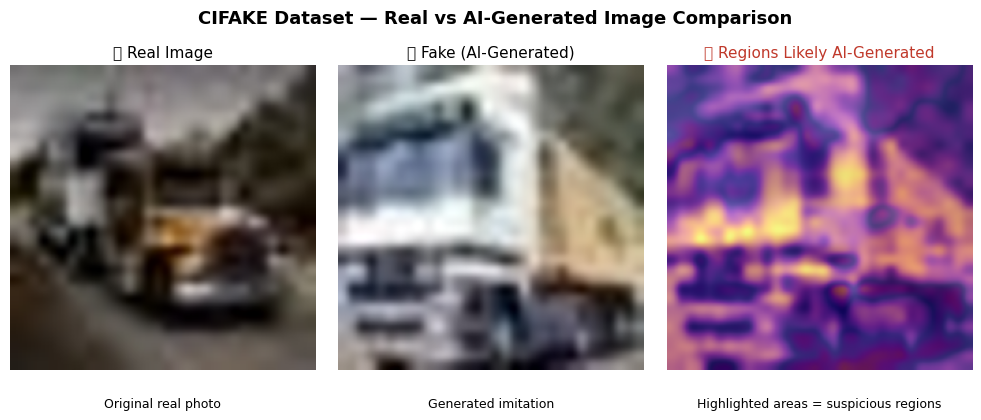

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Make sure CIFAKE is loaded
cifake = load_cifake('train')

# Pick one real and one fake image
real_idx = next(i for i in range(len(cifake)) if cifake[i][1] == 0)
fake_idx = next(i for i in range(len(cifake)) if cifake[i][1] == 1)
real_img, _ = cifake[real_idx]
fake_img, _ = cifake[fake_idx]

# Undo normalization
def denorm(x):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3,1,1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3,1,1)
    return (x * std + mean).clamp(0, 1)

real_disp = denorm(real_img).permute(1,2,0).numpy()
fake_disp = denorm(fake_img).permute(1,2,0).numpy()

# Create a visual "fake detection" map (simple difference)
diff_map = np.abs(real_disp - fake_disp).mean(axis=-1)
diff_map = cv2.GaussianBlur(diff_map, (5,5), 0)
diff_map = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-8)

# Convert heatmap to nice colormap (plasma) and overlay
heat = plt.cm.plasma(diff_map)[..., :3]
overlay = (0.6 * fake_disp + 0.8 * heat) / 1.4
overlay = np.clip(overlay, 0, 1)

# Plot
plt.figure(figsize=(10,4))
plt.suptitle("CIFAKE Dataset — Real vs AI-Generated Image Comparison", fontsize=13, weight='bold')

# Real
plt.subplot(1,3,1)
plt.imshow(real_disp)
plt.title("🖼️ Real Image", fontsize=11)
plt.axis("off")
plt.text(0.5, -0.12, "Original real photo", fontsize=9, ha="center", transform=plt.gca().transAxes)

# Fake
plt.subplot(1,3,2)
plt.imshow(fake_disp)
plt.title("🎨 Fake (AI-Generated)", fontsize=11)
plt.axis("off")
plt.text(0.5, -0.12, "Generated imitation", fontsize=9, ha="center", transform=plt.gca().transAxes)

# Fake + overlay
plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("🔥 Regions Likely AI-Generated", fontsize=11, color="#c0392b")
plt.axis("off")
plt.text(0.5, -0.12, "Highlighted areas = suspicious regions", fontsize=9, ha="center", transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


it highlights which areas of the fake image differ most from how a real image of the same kind usually looks.